In [1]:
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [2]:
custom_colors = ['#784888', '#94b3c4', '#897cac', '#d8bfd4', '#f6e8e7']
#custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
#complementary_colors = ['#a9d0f5', '#f3ba8c', '#98e698', '#f5a9a9', '#d8b5d8', '#d2a6a6', '#f5a9f2', '#d8d8d8']

#full_palette = custom_colors + complementary_colors
#sns.set_palette(full_palette)

sns.set_palette(custom_colors)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams['legend.fontsize'] =30

In [3]:
df = pd.read_pickle('../data/depresjon/depresjon_preprocessed.pkl')
df = df[df['category_madrs'].notna()]
df

,timestamp,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1052265600000000000,1,174.144444,11,0,0,2.0,2.0,2.0,1,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1052352000000000000,1,156.247222,11,0,0,2.0,2.0,2.0,1,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1052438400000000000,1,124.135417,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1052524800000000000,1,134.961806,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1052611200000000000,1,99.439583,11,0,0,2.0,2.0,2.0,1,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1086480000000000000,9,162.295833,13,0,1,1.0,2.0,2.0,1,...,-0.781831,-0.781831,-0.481754,0.937752,0.623490,0.623490,0.876307,0.347305,1,0
401,1086566400000000000,9,224.508333,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.000000,-0.24869,0.988468,0.623490,1.000000,0.968583,0.151428,1,2
402,1086652800000000000,9,202.056250,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.781831,-0.24869,0.998717,0.623490,0.623490,0.968583,-0.050649,1,2
403,1086739200000000000,9,168.656250,13,0,1,1.0,2.0,2.0,1,...,-0.781831,0.974928,-0.24869,0.968077,0.623490,-0.222521,0.968583,-0.250653,1,1


In [4]:
df.columns

Index(['timestamp', 'user_id', 'activity', 'days', 'gender', 'age', 'afftype',
       'melanch', 'inpatient', 'edu', 'marriage', 'work', 'is_weekend',
       'category_madrs', 'month_sin', 'weekday_sin', 'week_sin', 'day_sin',
       'month_cos', 'weekday_cos', 'week_cos', 'day_cos', 'activity_quantile',
       'user_activity_quantile'],
      dtype='object')

In [5]:
df['age'].value_counts()

age
0    215
1    174
Name: count, dtype: int64

In [6]:
df['gender'].value_counts()

gender
0    220
1    169
Name: count, dtype: int64

In [7]:
df['category_madrs'].value_counts()

category_madrs
0    201
1    188
Name: count, dtype: int64

# Significant relations between labels and protected attributes

In [8]:
demographic_variables = ['age', 'gender']
target_variables = ['category_madrs']

def perform_chi2_test(df, demographic_variable, target_variable):
    contingency_table = pd.crosstab(df[demographic_variable], df[target_variable])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

results_df = pd.DataFrame(columns=['Demographic Variable', 'Target Variable', 'Chi-square Statistic', 'p-value'])

for demographic_variable in demographic_variables:
    for target_variable in target_variables:
        chi2, p = perform_chi2_test(df, demographic_variable, target_variable)
        temp_df = pd.DataFrame({
            'Demographic Variable': [demographic_variable],
            'Target Variable': [target_variable],
            'Chi-square Statistic': [chi2],
            'p-value': [p]
        })
        results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df

C:\Users\ChristinaKaragianni\AppData\Local\Temp\ipykernel_11800\1531411176.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


,Demographic Variable,Target Variable,Chi-square Statistic,p-value
0,age,category_madrs,19.413992,0.000011
1,gender,category_madrs,15.406562,0.000087


if p<0.05 there is a significant relation

Both demographic variables (age and gender) have a significant association with the category_madrs. This suggests that the distribution of individuals across the different MADRS categories is not uniform across different age groups or between genders. These findings could indicate potential disparities or biases related to age and gender in the way individuals are categorized by the MADRS.

# Representation bias

In [9]:
ratios = {
    'Category': ['gender', 'age'],
    'Dataset Ratios': [0.54, 0.53], # male, below 45
    'Real EU Ratios': [0.48, 0.56] # male, below 45
}

ratios_df = pd.DataFrame(ratios)
ratios_df

,Category,Dataset Ratios,Real EU Ratios
0,gender,0.54,0.48
1,age,0.53,0.56


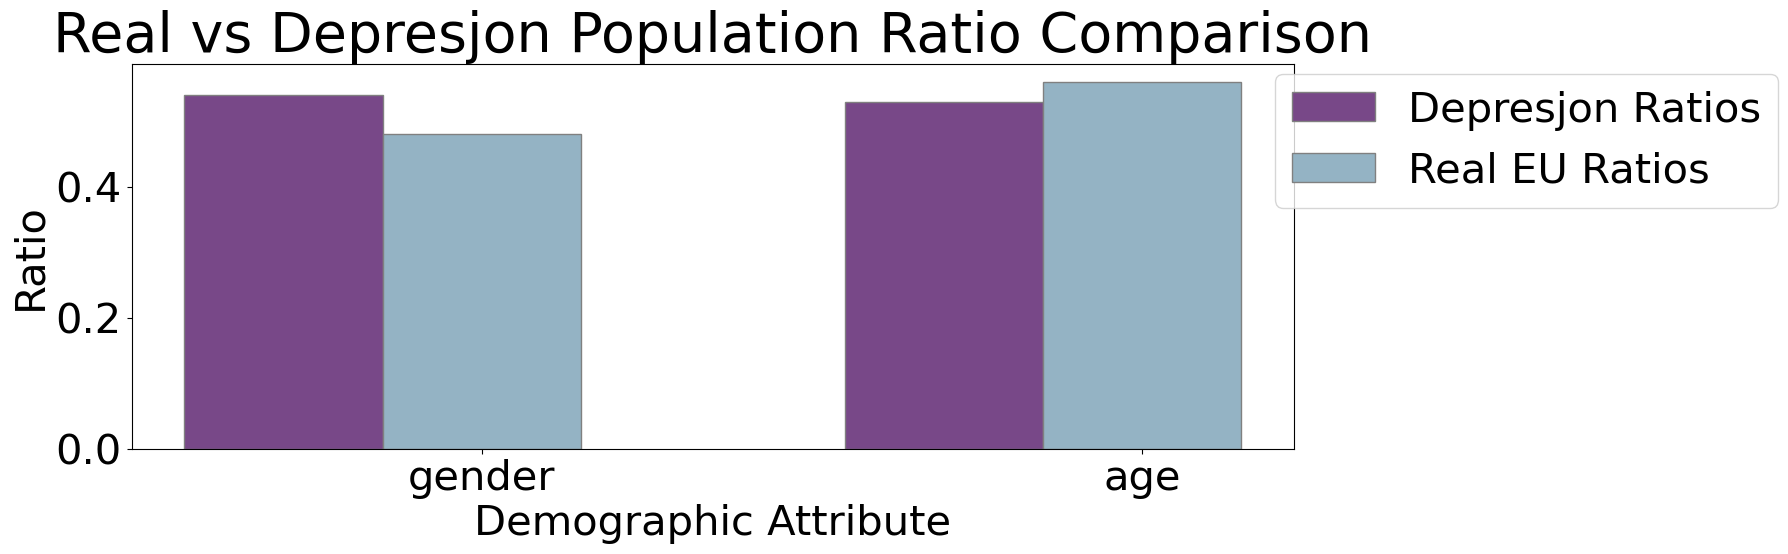

In [10]:
plt.figure(figsize=(15, 5))

barWidth = 0.3

r1 = range(len(ratios_df))
r2 = [x + barWidth for x in r1]

plt.bar(r1, ratios_df['Dataset Ratios'], color='#784888', width=barWidth, edgecolor='grey', label='Depresjon Ratios')
plt.bar(r2, ratios_df['Real EU Ratios'], color='#94b3c4', width=barWidth, edgecolor='grey', label='Real EU Ratios')

plt.xlabel('Demographic Attribute')
plt.xticks([r + barWidth for r in range(len(ratios_df))], ratios_df['Category'])
plt.ylabel('Ratio')
plt.title('Real vs Depresjon Population Ratio Comparison')
plt.legend(loc='center', bbox_to_anchor=(1.2, 0.8), ncol=1)
plt.savefig("../visualizations/depresjon/representation-biasDepresjon.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/representation-biasDepresjon.eps",bbox_inches='tight')
plt.show()

# Data biases

In [11]:
df = df.drop(columns=['user_id'])
df

,timestamp,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1052265600000000000,174.144444,11,0,0,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1052352000000000000,156.247222,11,0,0,2.0,2.0,2.0,1,1.0,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1052438400000000000,124.135417,11,0,0,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1052524800000000000,134.961806,11,0,0,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1052611200000000000,99.439583,11,0,0,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,1086480000000000000,162.295833,13,0,1,1.0,2.0,2.0,1,1.0,...,-0.781831,-0.781831,-0.481754,0.937752,0.623490,0.623490,0.876307,0.347305,1,0
401,1086566400000000000,224.508333,13,0,1,1.0,2.0,2.0,1,1.0,...,-0.781831,0.000000,-0.24869,0.988468,0.623490,1.000000,0.968583,0.151428,1,2
402,1086652800000000000,202.056250,13,0,1,1.0,2.0,2.0,1,1.0,...,-0.781831,0.781831,-0.24869,0.998717,0.623490,0.623490,0.968583,-0.050649,1,2
403,1086739200000000000,168.656250,13,0,1,1.0,2.0,2.0,1,1.0,...,-0.781831,0.974928,-0.24869,0.968077,0.623490,-0.222521,0.968583,-0.250653,1,1


In [12]:
protected_attributes = ['gender', 'age']
privileged_classes = [[0], [0]] # male, below 45 years old

dataset = StandardDataset(df,
                          label_name='category_madrs',
                          favorable_classes=[1],  # not a favorable outcome, but perhaps the most important or most desorable
                          protected_attribute_names=protected_attributes,
                          privileged_classes=privileged_classes)

df_bias_columns_metric = pd.DataFrame(columns=['protected_attribute', 'statistical_parity_difference', 'disparate_impact_ratio'])

for attr in dataset.protected_attribute_names:
    print("\nEvaluating Outcome Bias for {}".format(attr))
    idx = dataset.protected_attribute_names.index(attr)
    privileged_groups = [{attr: dataset.privileged_protected_attributes[idx][0]}]
    unprivileged_groups = [{attr: dataset.unprivileged_protected_attributes[idx][0]}]

    metric_data = BinaryLabelDatasetMetric(dataset, unprivileged_groups=unprivileged_groups,
                                           privileged_groups=privileged_groups)

    # Using mean_difference() value as Statistical Parity Difference for explicit naming
    spd = metric_data.mean_difference()

    df_bias_columns_metric.loc[len(df_bias_columns_metric.index)] = [attr, spd, metric_data.disparate_impact()]

    print("Group Fairness - Statistical Parity Difference: {}".format(spd))
    print("Group Fairness - Disparate Impact Ratio: {}".format(metric_data.disparate_impact()))

df_bias_columns_metric


Evaluating Outcome Bias for gender
Group Fairness - Statistical Parity Difference: -0.20586336740182898
Group Fairness - Disparate Impact Ratio: 0.6405560251714097

Evaluating Outcome Bias for age
Group Fairness - Statistical Parity Difference: -0.22972467254744722
Group Fairness - Disparate Impact Ratio: 0.6080094873198322


,protected_attribute,statistical_parity_difference,disparate_impact_ratio
0,gender,-0.205863,0.640556
1,age,-0.229725,0.608009


Statistical Parity Difference measures the difference in the rate of favorable outcomes received by the unprivileged group compared to the privileged group. A value of 0 indicates perfect fairness. Disparate Impact Ratio measures the ratio of probabilities of favorable outcomes for the unprivileged group to that of the privileged group. A value of 1 indicates perfect fairness, values less than 1 indicate less favorable outcomes for the unprivileged group, and values greater than 1 indicate more favorable outcomes for the unprivileged group.

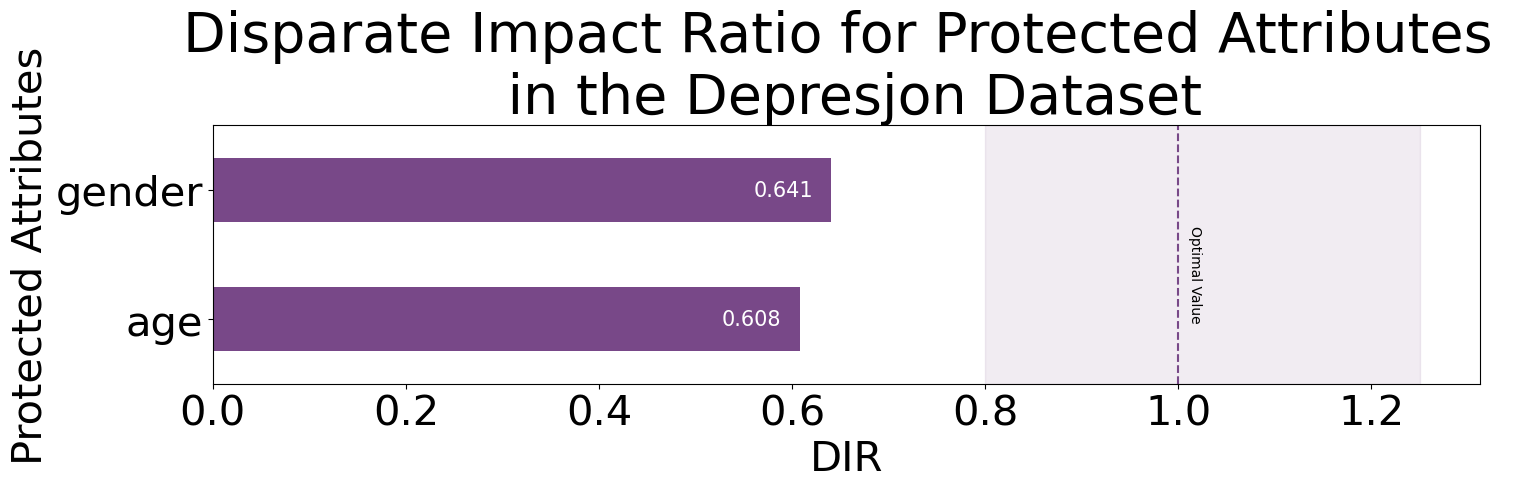

In [13]:
df_bias_columns_metric['Label'] = 'madrs'
pivot_df = df_bias_columns_metric.pivot(index='protected_attribute', columns='Label', values='disparate_impact_ratio')


pivot_df.plot(kind='barh', figsize=(15, 5), legend=False)

# Add the vertical line and shaded area
plt.axvline(x=1.0, color='#784888', linestyle='--')
plt.axvspan(0.8, 1.25, color='#784888', alpha=0.1)
plt.text(1.01, 0, 'Optimal Value', rotation=270)

# Set labels and title
plt.ylabel('Protected Attributes')
plt.xlabel('DIR')
plt.title('Disparate Impact Ratio for Protected Attributes \n in the Depresjon Dataset')

# Adding the values at the end of each bar, slightly to the left
for i in range(len(pivot_df)):
    for j in range(len(pivot_df.columns)):
        value = pivot_df.iloc[i, j]
        plt.text(value - 0.05, i, f'{value:.3f}', ha='center', va='center', color='white', size=15)


# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("../visualizations/depresjon/dir-data-biasdepresjon.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/dir-data-biasdepresjon.eps",bbox_inches='tight')
plt.show()

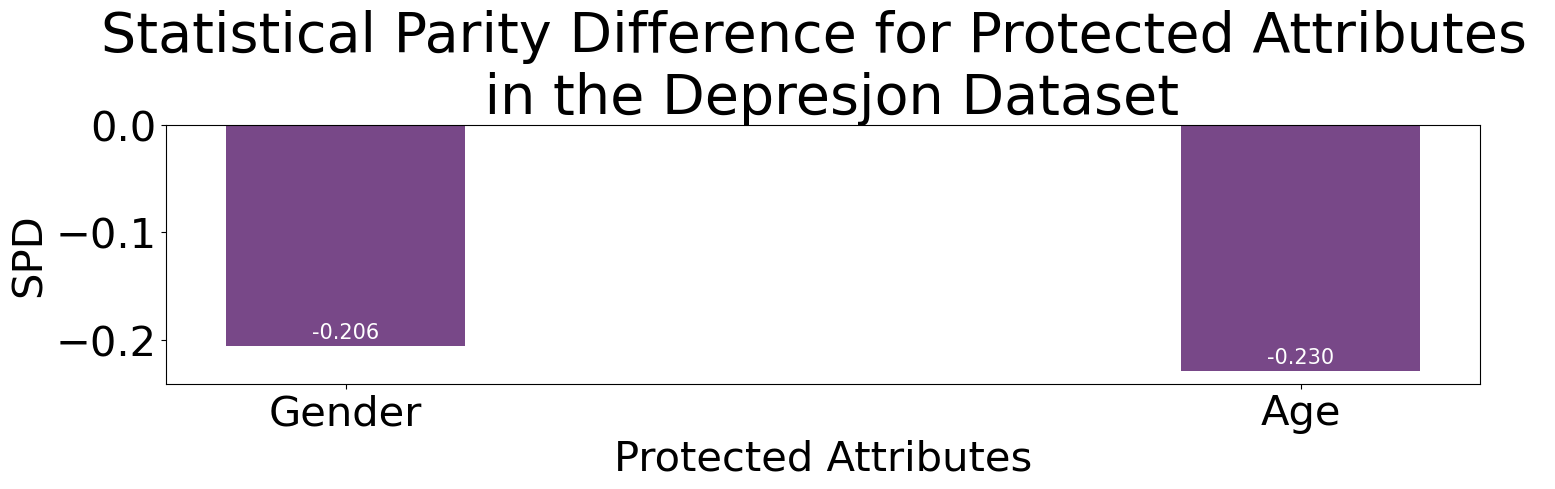

In [14]:
# Corrected assignments for each measure
spd_madrs = np.array([-0.205863, -0.229725])  

attributes = ['Gender', 'Age']
x = np.arange(len(attributes))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x, spd_madrs, width, label='MADRS')  # Center the bars at 'x'

ax.set_ylabel('SPD')
ax.set_title('Statistical Parity Difference for Protected Attributes \n in the Depresjon Dataset')
ax.set_xticks(x)  # Ensure x-ticks align with the bar centers
ax.set_xticklabels(attributes)
plt.xlabel('Protected Attributes')
# ax.legend()  # Remove or comment out the legend

# Function to attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', color='white', size=15)

autolabel(rects1)
fig.tight_layout()
plt.savefig("../visualizations/depresjon/spd-data-biasdepresjon.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/spd-data-biasdepresjon.eps",bbox_inches='tight')
plt.show()

# Model bias

In [15]:
X_test = pd.read_csv('../data/depresjon/predictions/depresjon_X_test_LOPO.csv')
y_test = pd.read_csv('../data/depresjon/predictions/depresjon_y_test_LOPO.csv')
y_pred = pd.read_csv('../data/depresjon/predictions/depresjon_y_pred_LOPO.csv')

print("Missing values in X_test:", X_test.isna().any().any())
print("Missing values in y_test:", y_test.isna().any())
print("Missing values in y_pred:", pd.DataFrame(y_pred).isna().any().any())

print(X_test.index)
print(y_test.index)
print(y_pred.index)

protected_attributes = ['gender', 'age']
privileged_classes = [[0], [0]] # male, below 45 years old

true_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test, y_test], axis=1),
    label_names=['category_madrs'],
    protected_attribute_names=protected_attributes
)

pred_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test, y_pred], axis=1),
    label_names=['category_madrs'],
    protected_attribute_names=protected_attributes
)

privileged_groups = [{'gender': 0, 'age': 0}]  # male, below 30 years old
unprivileged_groups = [{'gender': 1, 'age': 1}]

dataset_metric = BinaryLabelDatasetMetric(
    true_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

classification_metric = ClassificationMetric(
    true_dataset,
    pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
print("----------------")
print("LOPO")
print("----------------")
print("Disparate Impact:", dataset_metric.disparate_impact())
print("Statistical Parity Difference:", dataset_metric.statistical_parity_difference())

Missing values in X_test: False
Missing values in y_test: category_madrs    False
dtype: bool
Missing values in y_pred: False
RangeIndex(start=0, stop=389, step=1)
RangeIndex(start=0, stop=389, step=1)
RangeIndex(start=0, stop=389, step=1)
----------------
LOPO
----------------
Disparate Impact: 2.3460101867572156
Statistical Parity Difference: 0.2959313176558418


In [16]:
X_test = pd.read_csv('../data/depresjon/predictions/depresjon_X_test_generic.csv')
y_test = pd.read_csv('../data/depresjon/predictions/depresjon_y_test_generic.csv')
y_pred = pd.read_csv('../data/depresjon/predictions/depresjon_pred_generic.csv')

print("Missing values in X_test:", X_test.isna().any().any())
print("Missing values in y_test:", y_test.isna().any())
print("Missing values in y_pred:", pd.DataFrame(y_pred).isna().any().any())

print(X_test.index)
print(y_test.index)
print(y_pred.index)

protected_attributes = ['gender', 'age']
privileged_classes = [[0], [0]] # male, below 45 years old

true_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test, y_test], axis=1),
    label_names=['category_madrs'],
    protected_attribute_names=protected_attributes
)

pred_dataset = BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=pd.concat([X_test, y_pred], axis=1),
    label_names=['category_madrs'],
    protected_attribute_names=protected_attributes
)

privileged_groups = [{'gender': 0, 'age': 0}]  # male, below 30 years old
unprivileged_groups = [{'gender': 1, 'age': 1}]

dataset_metric = BinaryLabelDatasetMetric(
    true_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

classification_metric = ClassificationMetric(
    true_dataset,
    pred_dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
print("----------------")
print("Generic")
print("----------------")
print("Disparate Impact:", dataset_metric.disparate_impact())
print("Statistical Parity Difference:", dataset_metric.statistical_parity_difference())

Missing values in X_test: False
Missing values in y_test: category_madrs    False
dtype: bool
Missing values in y_pred: False
RangeIndex(start=0, stop=93, step=1)
RangeIndex(start=0, stop=93, step=1)
RangeIndex(start=0, stop=93, step=1)
----------------
Generic
----------------
Disparate Impact: inf
Statistical Parity Difference: 1.0


C:\Users\ChristinaKaragianni\anaconda3\envs\myy\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


In [17]:
dir_data = {
    'Model': ['MADRS'],
    'Generic': [2.35],
    'Personalized': [np.inf]
}

spd_data = {
    'Model': ['MADRS'],
    'Generic': [0.3],
    'Personalized': [1]
}

dir_df = pd.DataFrame(dir_data)
spd_df = pd.DataFrame(spd_data)

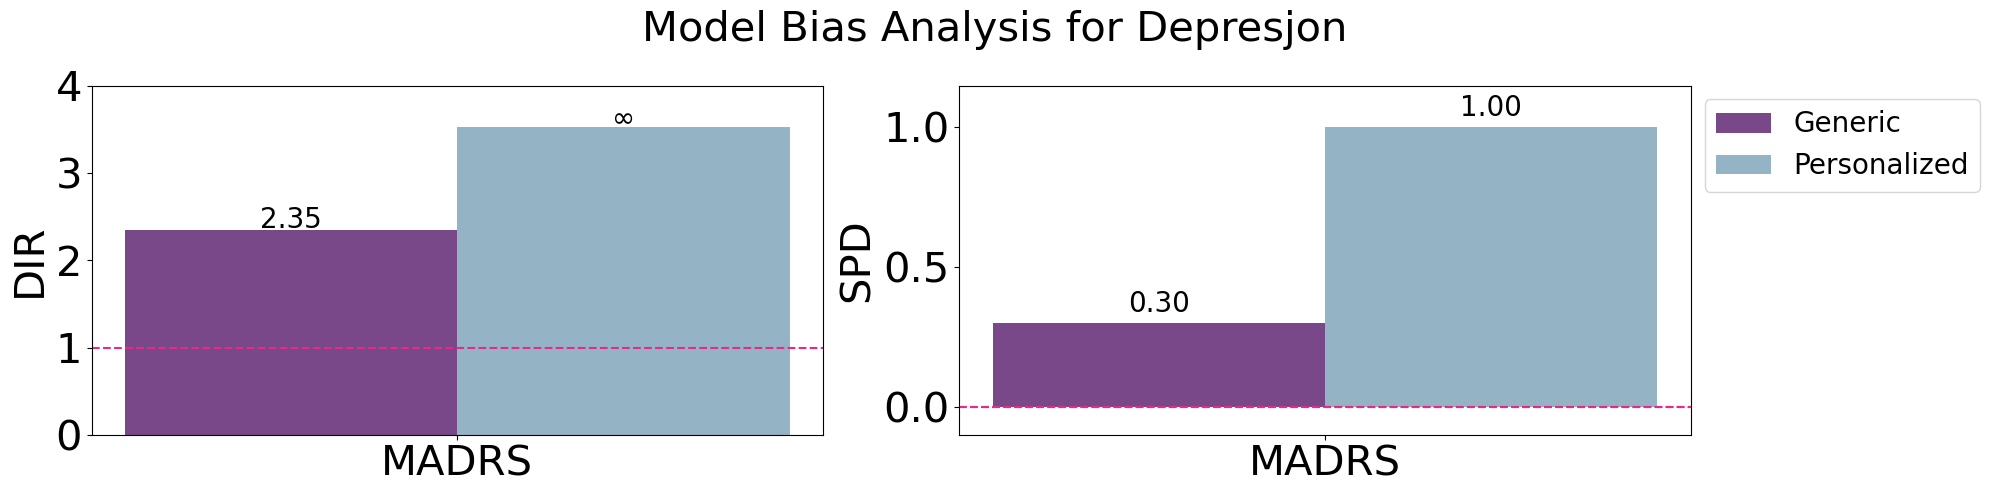

In [18]:
dir_df_visual = dir_df.replace(np.inf, dir_df['Generic'].max() * 1.5)  

fig, axes = plt.subplots(1, 2, figsize=(20, 5), tight_layout=True)

bar_positions_generic = np.arange(len(dir_df['Model']))  # generic model bar positions
bar_positions_personalized = bar_positions_generic + width  

axes[0].bar(bar_positions_generic, dir_df_visual['Generic'], width, label='Generic')
axes[0].bar(bar_positions_personalized, dir_df_visual['Personalized'], width, label='Personalized')
axes[0].axhline(y=1, color='#e72a8a', linestyle='--')

# Adding text labels above bars for DIR
for index, value in enumerate(dir_df['Generic']):
    axes[0].text(index, value + 0.02, f'{value:.2f}', ha='center', fontsize=20)
for index, value in enumerate(dir_df['Personalized']):
    if np.isinf(value):  # Handle the case for infinity
        axes[0].text(index + width, dir_df_visual['Personalized'].iloc[0], '∞', ha='center', fontsize=20)
    else:
        axes[0].text(index + width, value + 0.01, f'{value:.2f}', ha='center')

# Set labels and titles for DIR
axes[0].set_ylabel('DIR')
axes[0].set_xticks(bar_positions_generic + width / 2)
axes[0].set_xticklabels(dir_df['Model'])
axes[0].set_ylim(0, 4)

# Bar plot for SPD
axes[1].bar(bar_positions_generic, spd_df['Generic'], width, label='Generic')
axes[1].bar(bar_positions_personalized, spd_df['Personalized'], width, label='Personalized')
axes[1].axhline(y=0, color='#e72a8a', linestyle='--')

# Adding text labels above bars for SPD
for index, value in enumerate(spd_df['Generic']):
    axes[1].text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom' if value < 0 else 'bottom', fontsize=20)
for index, value in enumerate(spd_df['Personalized']):
    axes[1].text(index + width, value + 0.02, f'{value:.2f}', ha='center', va='bottom' if value < 0 else 'bottom', fontsize=20)

# Set labels and titles for SPD
axes[1].set_ylabel('SPD')
axes[1].set_xticks(bar_positions_generic + width / 2)
axes[1].set_xticklabels(spd_df['Model'])
axes[1].axhline(y=0, color='#e72a8a', linestyle='--')
axes[1].set_ylim(-0.1, 1.15)

# Add legend and title
#axes[0].legend()
axes[1].legend(bbox_to_anchor=(1, 1), fontsize=20)
fig.suptitle('Model Bias Analysis for Depresjon', size=30)

plt.savefig("../visualizations/depresjon/depresjon-model-bias.png",bbox_inches='tight')
plt.savefig("../visualizations/depresjon/depresjon-model-bias.eps",bbox_inches='tight')

plt.show()